# 1 Import Packages

In [ ]:
import xarray as xr
import numpy as np
import os

import src.config as config
import src.utils as utils

import sklearn.linear_model
from tqdm import tqdm

import matplotlib.pyplot as plt

# 2 Metadata

In [ ]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform")

In [ ]:
lev_index = 0

In [ ]:
train_x_filename = "train_data_stack_lonlatstandardized.nc"
valid_x_filename = "valid_data_stack_lonlatstandardized.nc"

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized.nc"
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized.nc"

# 3 Load Data

In [ ]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename)).isel(lev=lev_index)
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename)).isel(lev=lev_index)

In [ ]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [ ]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

# 4 Processing

In [ ]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time")).stack(feature=("lon","lat"))

feature_coords = train_x_xr_stack.feature
sample_coords = train_x_xr_stack.sample

train_x_xr_stack_dropna = train_x_xr_stack.dropna(dim="feature")
valid_x_xr_stack_dropna = valid_x_xr_stack.dropna(dim="feature")

feature_dropna_coords = train_x_xr_stack_dropna.feature

In [ ]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


# 5 Model

In [ ]:
train_pred_xr = xr.DataArray(train_pred, dims= ["sample"], coords = {"sample": train_x_xr_stack.sample})
valid_pred_xr = xr.DataArray(valid_pred, dims= ["sample"], coords = {"sample": valid_x_xr_stack.sample})


In [ ]:
train_pred_xr_sv = train_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd["atlantic_moc"] + train_data_amoc_depth_1020_lat_26_samplemean["atlantic_moc"]
valid_pred_xr_sv = valid_pred_xr*train_data_amoc_depth_1020_lat_26_samplestd["atlantic_moc"] + train_data_amoc_depth_1020_lat_26_samplemean["atlantic_moc"]

In [ ]:
train_y_xr_sv = train_y_xr*train_data_amoc_depth_1020_lat_26_samplestd["atlantic_moc"] + train_data_amoc_depth_1020_lat_26_samplemean["atlantic_moc"]
valid_y_xr_sv = valid_y_xr*train_data_amoc_depth_1020_lat_26_samplestd["atlantic_moc"] + train_data_amoc_depth_1020_lat_26_samplemean["atlantic_moc"]

In [ ]:
valid_pred_xr = xr.DataArray(valid_pred, dims = ["sample"], coords = {"sample":valid_y_xr_stack.sample}) 
train_pred_xr = xr.DataArray(train_pred, dims = ["sample"], coords = {"sample":train_y_xr_stack.sample}) 

In [ ]:
model_coef_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_dropna_coords} )

In [ ]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

feature_drop_coords = train_x_xr_stack_dropna.feature
feature_full_coords = train_x_xr_stack.feature 

train_x_ml_xr = train_x_xr_stack_dropna["rho"]
valid_x_ml_xr = valid_x_xr_stack_dropna["rho"]

train_y_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_ml_xr = valid_y_xr_stack["atlantic_moc"]

train_y_true_ml_xr = train_y_xr_stack["atlantic_moc"]
valid_y_true_ml_xr = valid_y_xr_stack["atlantic_moc"]


In [ ]:
def mse_xr(pred, true, sample_dim = "sample"):
    return np.square(pred - true).mean(dim=sample_dim)

In [ ]:
alpha_list = np.logspace(-2,3, 100)

In [ ]:
train_mse_list = []
valid_mse_list = []


for i,alpha in tqdm(enumerate(alpha_list)): 
    
    model = sklearn.linear_model.Ridge(alpha = alpha)
    
    model.fit(train_x_ml_xr, train_y_ml_xr)
    
    model_coef_ml_xr = xr.DataArray(model.coef_, dims = ["feature"], coords ={"feature":feature_drop_coords} )
    model_coef_tmp,_ = xr.align(model_coef_ml_xr, feature_coords, join="outer")

    train_y_pred_ml_np = model.predict(train_x_ml_xr)
    valid_y_pred_ml_np = model.predict(valid_x_ml_xr)

    train_y_pred_ml_xr = xr.DataArray(train_y_pred_ml_np, dims= ["sample"], coords = {"sample": train_sample_coords, "alpha":alpha})
    valid_y_pred_ml_xr = xr.DataArray(valid_y_pred_ml_np, dims= ["sample"], coords = {"sample": valid_sample_coords, "alpha":alpha})


    train_mse_tmp = mse_xr(train_y_pred_ml_xr, train_y_true_ml_xr)
    valid_mse_tmp = mse_xr(valid_y_pred_ml_xr, valid_y_true_ml_xr)


    if i == 0: 
        model_coef = model_coef_tmp.assign_coords({"alpha": alpha})
        train_mse = train_mse_tmp.assign_coords({"alpha":alpha})
        valid_mse = valid_mse_tmp.assign_coords({"alpha":alpha})
        train_pred = train_y_pred_ml_xr.assign_coords({"alpha":alpha})
        valid_pred = valid_y_pred_ml_xr.assign_coords({"alpha":alpha})

    else:
        model_coef = xr.concat([model_coef, model_coef_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_mse = xr.concat([train_mse, train_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        valid_mse = xr.concat([valid_mse, valid_mse_tmp.assign_coords({"alpha":alpha})], dim="alpha")
        train_pred = xr.concat([train_pred, train_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        valid_pred = xr.concat([valid_pred, valid_y_pred_ml_xr.assign_coords({"alpha":alpha})], dim="alpha")
        

    data = xr.merge([
        model_coef.rename("coefficients"),
        train_mse.rename("train_mse"), 
        valid_mse.rename("valid_mse"),
        valid_pred.rename("valid_pred"),
        train_pred.rename("train_pred"),
        ])


0it [00:00, ?it/s]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.75752e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
1it [00:02,  2.50s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.05339e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
2it [00:04,  2.04s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.43469e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
3it [00:05,  1.82s/it]/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/sklearn/linear_model/_ridge.

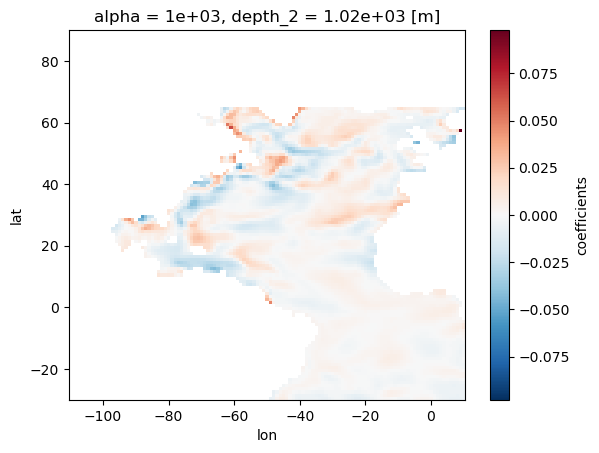

In [ ]:
data["coefficients"].isel(alpha=-1).unstack().transpose().plot.pcolormesh()

Text(0, 0.5, 'Error')

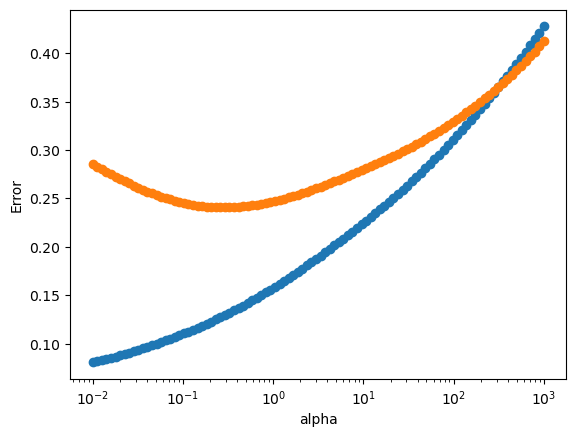

In [19]:
plt.scatter(data.alpha, data["train_mse"])
plt.scatter(data.alpha, data["valid_mse"])
plt.xscale("log")

plt.xlabel("alpha")
plt.ylabel("Error")

In [ ]:
valid_y_true_ml_xr

In [21]:
data["valid_pred"].sel(alpha=100,method="nearest")

<xarray.DataArray 'valid_pred' (sample: 9360)>
array([       nan,        nan,        nan, ..., 0.96689546, 0.9423026 ,
       0.36504626], dtype=float32)
Coordinates:
    alpha        float64 97.7
    depth_2      float64 1.02e+03
  * sample       (sample) object MultiIndex
  * realization  (sample) object 'lkm0001' 'lkm0001' ... 'lkm0060' 'lkm0060'
  * time         (sample) datetime64[ns] 1850-07-16T11:15:00 ... 2005-07-16T1...